# Dogs and cats... redux edition!

### Choosing sample vs main data set
You always want to first run your code on the sample set, to ensure that functions
and the like are working as expected, before going on to the full data set.
Comment out whichever set you are not going to use

In [1]:
path = "data/dogscatsredux/"
#path = "data/dogscatsredux/sample/"

In [2]:
from __future__ import division, print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [3]:
from numpy.random import random, permutation
from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom

import keras

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, cuDNN 5103)


In [4]:
# Lets define the blocks that make up VGG16

def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(keras.layers.convolutional.ZeroPadding2D((1,1)))
        model.add(keras.layers.convolutional.Convolution2D(filters, 3, 3, activation='relu'))
    model.add(keras.layers.convolutional.MaxPooling2D((2,2), strides=(2,2)))
    
def FCBlock(model):
    model.add(keras.layers.core.Dense(4096, activation='relu'))
    model.add(keras.layers.core.Dropout(0.5))

In [5]:
# The vgg16 model requires a preprocessing step -- It is defined here

def vgg_preprocessing(x):
    x = x - np.array([123.68, 116.779, 103.939]).reshape((3,1,1))
    return x[:, ::-1]

In [6]:
# Building up the actual model.  For further information, see the following paper:
# Very Deep Convolutional Networks for Large-Scale Image Recognition -- arXiv:1409.1556

def VGG_16():
    model = keras.models.Sequential()
    model.add(keras.layers.core.Lambda(vgg_preprocessing, input_shape=(3,224,224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(keras.layers.core.Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(keras.layers.core.Dense(1000, activation='softmax'))
    return model

In [7]:
# Instantiate model and populate it with downloaded weights from fast.ai website
import keras.utils.data_utils
FILES_PATH = 'http://files.fast.ai/models/'
fpath = keras.utils.data_utils.get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir="models")
model = VGG_16()
model.load_weights(fpath)

/home/tamie/Envs/fast.ai/local/lib/python3.5/site-packages/keras/layers/core.py:622: UserWarning: `output_shape` argument not specified for layer lambda_1 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


# Creating new model

Our plan is to remove the final layer of vgg16 to expose the 4096 outputs of the previous fully-connected layer.
The initial vgg16 network in its entirety had to be recreated, though; keras does not allow us to load weights
that were designed for a different network, it throws an error.  Therefore, after loading all of these weights, we
will now proceed with creating a new model, now with the last layer removed.

We will attempt several methods to then create a binary classifier for the dogs and cats dataset, the first of which will be an SVM which will be trained on top of that 4096 output.

In [8]:
# Creating cut-off model with 4096-output layer exposed, pre-ReLU
features_model = keras.models.Model(input=model.input,
                       output=model.get_layer("dense_2").output)

In [9]:
# Model loaded.  Lets create some batches, and set a seed value.  This is necessary in order to guarantee
# consistent batch creations between different calls to get_batch.

import keras.preprocessing.image
batch_size = 64    # We are not training a neural network, should not be an issue for it to be large.
seed = 42
def get_batches(dirname, gen=keras.preprocessing.image.ImageDataGenerator(), 
                shuffle=True, batch_size=batch_size, class_mode='categorical',
                seed=None):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), class_mode=class_mode,
                                   shuffle=shuffle, batch_size=batch_size, seed=seed)

In [10]:
# Get our sets of batches~  We need both training and validation batches.
batches = get_batches('train', seed=seed, batch_size=batch_size)
val_batches = get_batches('valid', seed=seed, batch_size=batch_size)

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [11]:
# We will now extract the 4096-dimensional output from our truncated vgg16 model
# It will be the input that the SVM will work with.
features_vec = features_model.predict_generator(batches,batches.nb_sample)

In [17]:
# Here are some useful functions for dealing with batches and the like.

def onehot_to_categorical(onehot_array, start_categories_at=0.0):
    ''' Converts one-hot representation in an array into a categorical one '''
    n_categories = onehot_array.shape[1]
    
    broadcast_array = np.arange(start_categories_at, start_categories_at + n_categories)
    broadcast_array = np.expand_dims(broadcast_array, axis=0)
    assert(broadcast_array.shape==(1,n_categories))
                                
    # Turn a one-hot [0,0,0,1] or [0,0,1,0] into [0,0,0,3] and [0,0,2,0] via broadcasting
    # shapes: onehot_array.shape = (?, n_categories) , broadcast_array = (1, n_categories)
    output_array = onehot_array * broadcast_array
    
    # Collapse output array along first dimension, turning [[0,0,0,3],[0,0,2,0],...] ->[3, 2, ....]
    output_array =np.sum(output_array, axis=1)
    return output_array                                                          
    
def get_classifications_from_batch(batches):
    ''' Takes a batch of labeled data, and returns an array of categorical classifications'''
    nb_samples = batches.nb_sample
    nb_classes = batches.nb_class
    batch_size = batches.batch_size
    nb_complete_batches = nb_samples // batch_size
    last_batch_size = nb_samples % batch_size
    
    onehot_array = np.empty((nb_samples, nb_classes), dtype=np.float32)
    
    for i in range(nb_complete_batches):
        batch = next(batches)
        onehot_array[i*batch_size : (i+1)*batch_size][:] = batch[1][:]
    #last incomplete batch
    batch = next(batches)
    onehot_array[nb_complete_batches*batch_size:][:] = batch[1][:]
    
    return onehot_to_categorical(onehot_array)

In [18]:
# Using the functions above, lets get our array of classifications for fitting the SVM
# Reset the batch generator.  The seed is identical, so the shuffle will be identical as well
batches = get_batches('train', seed=seed, batch_size=batch_size)

train_ground_truth = get_classifications_from_batch(batches)

Found 22500 images belonging to 2 classes.


In [19]:
# It's time to sklearn!  Lets fit that SVM to the VGG16 output on the training set

from sklearn import svm
classifier = svm.SVC(C=.8, kernel='linear')

assert features_vec.shape[0] == train_ground_truth.shape[0]
print(features_vec.shape)
print(train_ground_truth.shape)

classifier.fit(features_vec, train_ground_truth)

(22500, 4096)
(22500,)


SVC(C=0.8, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [20]:
# Alright!  Lets get predictions for the validation batch and see how we did
val_batches = get_batches('valid', seed=seed, batch_size=batch_size)

# Pass them through vgg
val_features_vec = features_model.predict_generator(val_batches,val_batches.nb_sample)

# Predict outputs
valid_pred_labels = classifier.predict(val_features_vec)

# Obtain ground truth
val_batches = get_batches('valid', seed=seed, batch_size=batch_size)
valid_ground_truth = get_classifications_from_batch(val_batches)

Found 2500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


## Accuracy Metrics
The natural metric to use for this task is accuracy.  However, dogs and cats redux instead uses log_loss.  One
option to deal with this fact is to first find the accuracy, then set dog detections to accuracy, and cat detections to 1-accuracy.

Another possible choice is to use the predict_proba function internal to the SVM, although this would require
instantiating the svm.SVC() object with a flag that instructs it to construct this function.  To construct it
is very expensive, so we may want to avoid it.

A third choice, is to instead use decision_function, which gives the distance of a value from the separating 
hyperplane, and then squash it into a probability using the logistic function.  

In [24]:
import sklearn.metrics

# First method - label certainty = accuracy
# Find both the accuracy and the logloss for both the training and validation sets.

# Accuracy & Log-loss for Validation set
accuracy = sklearn.metrics.accuracy_score(valid_ground_truth, valid_pred_labels)
print("validation accuracy = {}".format(accuracy))
log_loss_labels = [accuracy if label==1 else (1-accuracy) for label in valid_pred_labels]
log_loss = sklearn.metrics.log_loss(valid_ground_truth, log_loss_labels)
print("validation log-loss = {}".format(log_loss))

# Accuracy & Log-loss for Training set
train_predicted_vec = classifier.predict(features_vec)
train_accuracy = sklearn.metrics.accuracy_score(train_ground_truth, train_predicted_vec)
print("training accuracy = {}".format(train_accuracy))
train_log_loss_labels = [train_accuracy if label==1 else 1-train_accuracy for label in train_predicted_vec]
train_log_loss = sklearn.metrics.log_loss(train_ground_truth, train_log_loss_labels)
print("training log-loss = {}".format(train_log_loss))

validation accuracy = 0.9828
validation log-loss = 0.08693217395254801
training accuracy = 1.0
training log-loss = 9.992007221626413e-16


In [31]:
# Third method, logistic function application on the SVM's decision_function

scale_factor = 4 # The higher this value, the steeper the logistic curve; the more confidence we have

# Logistic decision_function log-loss for Validation set
val_dec_func_out = classifier.decision_function(val_features_vec)
val_logistic_out = 1 / (1 + np.exp(val_dec_func_out*(-1*scale_factor)))
val_logistic_log_loss = sklearn.metrics.log_loss(valid_ground_truth, val_logistic_out)
print("logistic validation log-loss = {}".format(val_logistic_log_loss))

# Logistic decision_function log-loss for Training set
train_dec_func_out = classifier.decision_function(features_vec)
train_logistic_out = 1 / (1 + np.exp(train_dec_func_out*(-1*scale_factor)))
train_logistic_log_loss = sklearn.metrics.log_loss(train_ground_truth, train_logistic_out)
print("logistic training log-loss = {}".format(train_logistic_log_loss))

logistic validation log-loss = 0.07142326302977367
logistic training log-loss = 0.0011200025693680967


In [32]:
# Lets get the test data
# We don't shufflefeatures_vec the test batch.  Good lord please don't shuffle a test batch ever again, ok thanks
test_batches = get_batches("test1", shuffle=False, batch_size=batch_size, class_mode=None)

# Just to avoid confusion and make sure we know which indicies are which:
print(val_batches.class_indices)

Found 12500 images belonging to 1 classes.
{'dog': 1, 'cat': 0}


In [33]:
# Now, lets do our predictions:

test_features = features_model.predict_generator(test_batches,test_batches.nb_sample)
pred_test_labels = classifier.predict(test_features)

# We are going to try both the first and third methods for generating probabilities.
score_test_labels = classifier.decision_function(test_features)

In [120]:
# Using the first method.
import re

def write_to_file_accuracy(filenames, predictions, accuracy, name):
    file_number_reg = re.compile(r'\d+')
    with open(name, 'w') as f:
        f.write("id,label\n")
        for filename, ele in zip(filenames, predictions):
            id_number = file_number_reg.findall(filename)[-1]
            f.write("{},".format(id_number))
            if (ele==1.):
                f.write("%.8f"%accuracy)
                f.write("\n")
            else:
                f.write("%.8f"%(1-accuracy))
                f.write("\n")
              
write_to_file_accuracy(test_batches.filenames, pred_test_labels, accuracy, path+'my_submission.csv')


In [122]:
# Using the second method.
scale_factor = 4
logistic_predictions = 1 / (1 + np.exp(score_test_labels*(-1*scale_factor)))

def write_to_file_directly(filenames, predictions, name):
    '''Writes predictions to a file.  Filename is a list of test file names'''
    file_number_reg = re.compile(r'\d+')
    with open(name, 'w') as f:
        f.write("imageId,isDog\n")
        for filename, pred in zip(filenames, predictions):
            id_number = file_number_reg.findall(filename)[-1]
            f.write("{},".format(id_number))
            f.write(str("%.8f" % pred))
            f.write("\n")

write_to_file_directly(test_batches.filenames, logistic_predictions, path+'my_submission_logistic.csv')

## Musings on results

The above outputs, when submitted to kagggle, resulted in terrible results.  The log-loss varied from between 1 and 4.  This is awful, considering that using no model or computation at all and just predicting .5 probability of dog every single time already nets you a log-loss of .69315.  In fact, below I will place a table containing lists of the different variations of the above methods and the results obtained:

| SVM Parameters Used               | SVM output processing used            |Training|Valid  |Kaggle |
|-----------------------------------|---------------------------------------|--------|-------|-------|
|default                            | accuracy                              |  31    | 3     | 7     |
|default                            | logistic w/ scale_factor=4            |  42    | 42    |  3    |



We have reason to believe that our SVM is overfitting, since our loglosses are way off.

One possible fix is to not use the actual accuracies, but instead reduce them by a factor so that we can beat the
.693 baseline.  If our model is doing -any- useful work at all, our log-loss using the accuracy method must, at some value of the parameters, be able to beat .693.  Likewise, the logistic method should also be able to beat .693, and this can potentially be achieved through a change in the scale factor.

## Modifications to SVM

Next, I'll try Linear SVMs.  They can be produced more quickly, and more quickly generate output.  They handle large sample sizes more easily as well.  I'll also vary their C values to see if it helps with the underfitting / overfitting problem.  The code to fire one up will be wholly contained within a function so that I can modify the parameters more easily.

In [46]:
def setup_linear_svm(train_features_vec, train_ground_truth, C=1):
    """Trains a LinearSVC Classifier"""
    classifier = svm.LinearSVC(C=C)
    classifier.fit(train_features_vec, train_ground_truth)
    return classifier

def return_accuracy(classifier, train_ground_truth, train_features_vec,
                   valid_ground_truth, valid_features_vec):
    """Given features and a classifier, returns training & validation accuracy and log-loss"""
    train_predictions = classifier.predict(train_features_vec)
    valid_predictions = classifier.predict(valid_features_vec)
    train_accuracy = sklearn.metrics.accuracy_score(train_ground_truth, train_predictions)
    valid_accuracy = sklearn.metrics.accuracy_score(valid_ground_truth, valid_predictions)
    train_probabilities = \
        [train_accuracy if pred==1 else 1-train_accuracy for pred in train_predictions]
    valid_probabilities = \
        [valid_accuracy if pred==1 else 1-valid_accuracy for pred in valid_predictions]
    train_log_loss = sklearn.metrics.log_loss(train_ground_truth, train_probabilities)
    valid_log_loss = sklearn.metrics.log_loss(valid_ground_truth, valid_probabilities)
    return train_accuracy, valid_accuracy, train_log_loss, valid_log_loss

def return_logistic_log_loss(classifier, train_ground_truth, train_features_vec,
                             valid_ground_truth, valid_features_vec, factor=1):
    """Given features and a classifier, returns the logistic log-loss"""
    train_decisions = classifier.decision_function(train_features_vec)
    valid_decisions = classifier.decision_function(valid_features_vec)
    train_probabilities = 1 / (1 + np.exp(-1*factor*train_decisions))
    valid_probabilities = 1 / (1 + np.exp(-1*factor*valid_decisions))
    train_log_loss = sklearn.metrics.log_loss(train_ground_truth, train_probabilities)
    valid_log_loss = sklearn.metrics.log_loss(valid_ground_truth, valid_probabilities)
    return train_log_loss, valid_log_loss

In [56]:
# I'm going to try to handle the overfitting problem by using different values of C
c_values = [1e-10,1e-09,1e-08,1e-07,1e-06,1e-05,1e-04,1e-03]

accuracy_labels = ["Training Accuracy = ",
                  "Validation Accuracy = ",
                  "Training log-loss = ",
                  "Validation log-loss = ",
                  "Training logistic log-loss = ",
                  "Validation logistic log-loss = "]
classifiers = []
for c_value in c_values:
    classifier = setup_linear_svm(features_vec, train_ground_truth, C=c_value)
    classifiers.append(classifier)
    print("---------- Linear classifier with C = {} -----------".format(c_value))
    print(classifier)
    accuracies = list(return_accuracy(classifier, train_ground_truth, features_vec, 
                    valid_ground_truth, val_features_vec))
    accuracies.extend(list(return_logistic_log_loss(
                            classifier, train_ground_truth, features_vec, valid_ground_truth,
                            val_features_vec)))
    assert len(accuracies)==len(accuracy_labels)
    for accuracy, label in zip(accuracies, accuracy_labels):
        print(label+str(accuracy))

---------- Linear classifier with C = 1e-10 -----------
LinearSVC(C=1e-10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Training Accuracy = 0.957244444444
Validation Accuracy = 0.9588
Training log-loss = 0.176604686913
Validation log-loss = 0.171739239366
Training logistic log-loss = 0.692002241405
Validation logistic log-loss = 0.69201260132
---------- Linear classifier with C = 1e-09 -----------
LinearSVC(C=1e-09, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
Training Accuracy = 0.959777777778
Validation Accuracy = 0.9636
Training log-loss = 0.168649740053
Validation log-loss = 0.156329321099
Training logistic log-loss = 0.682097448934
Validation logistic log-loss = 0.682197439145
---

In [63]:
# C = 1e-08 seems to be the correct setting to reduce overfitting.  This is the 3rd classifier
# in the list of classifiers.  I believe the logistic log-loss can be improved, however.
# Lets try tuning the parameter "factor" a bit.

classifier = classifiers[2]

for factor in [20,30,40,50,60,70,80,90,100]:
    loss = return_logistic_log_loss(classifier, train_ground_truth, features_vec, 
                                valid_ground_truth, val_features_vec,factor=factor)
    print("--- logistic log loss with factor value {} ---".format(factor))
    print("Training logistic log-loss : {}".format(loss[0]))
    print("Validation logistic log-loss : {}".format(loss[1]))


--- logistic log loss with factor value 20 ---
Training logistic log-loss : 0.10945665029583207
Validation logistic log-loss : 0.11145230574083309
--- logistic log loss with factor value 30 ---
Training logistic log-loss : 0.08136030909713177
Validation logistic log-loss : 0.08425028253258113
--- logistic log loss with factor value 40 ---
Training logistic log-loss : 0.07457676584682908
Validation logistic log-loss : 0.07890561395232125
--- logistic log loss with factor value 50 ---
Training logistic log-loss : 0.07541170528132894
Validation logistic log-loss : 0.08134089508396328
--- logistic log loss with factor value 60 ---
Training logistic log-loss : 0.0796287015388114
Validation logistic log-loss : 0.08718363295065167
--- logistic log loss with factor value 70 ---
Training logistic log-loss : 0.08559986843573429
Validation logistic log-loss : 0.09476575700320303
--- logistic log loss with factor value 80 ---
Training logistic log-loss : 0.09258918098050452
Validation logistic log

In [124]:
# It seems that a factor of around 40 is optimal, but I feel skeptical.  For one thing, even a
# factor value of 4 was resulting in terrible test performance.  We can try, though!  The model
# is not overfitting.  It should... (should) work!
test_dec_func_out = classifier.decision_function(test_features)
test_probabilities = 1 / (1 + np.exp(-40*test_dec_func_out))
write_to_file_directly(test_batches.filenames, test_probabilities, path+"logistic_c4_f40.csv")

# I'll try one with a lot more tame factor of four as well
test_probabilities = 1 / (1 + np.exp(-4*test_dec_func_out))
write_to_file_directly(test_batches.filenames, test_probabilities, path+"logistic_c4_f4.csv")

In [116]:
# Apparently, all of these attempts failed.  My classifications are still grossly inaccurate,
# somehow.  I don't know how, but I literally just cannot beat the .5 benchmark  Let me 
# look at some images to see if it helps.

test_batches = get_batches("test1", shuffle=False, batch_size=batch_size, class_mode=None)

from keras.preprocessing import image
from utils import plots
def plots_idx(batches, idx, titles=None):
    plots([image.load_img(path+'test1/'+batches.filenames[i]) for i in idx], titles=titles)
    [print("{} : {}".format(batches.filenames[i], i)) for i in idx]
    
# A few dog-labeled images
dog_indices = np.where(test_probabilities>.5)
#print(test_probabilities.shape)
#print(dog_indices)
five_dog_indices = dog_indices[0][:5]
#print(five_dog_indices)


Found 12500 images belonging to 1 classes.


test/7517.jpg : 0
test/4417.jpg : 6
test/11831.jpg : 7
test/5572.jpg : 8
test/7158.jpg : 10


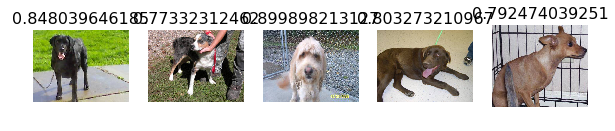

In [117]:
%matplotlib inline
plots_idx(test_batches, five_dog_indices, test_probabilities[five_dog_indices])

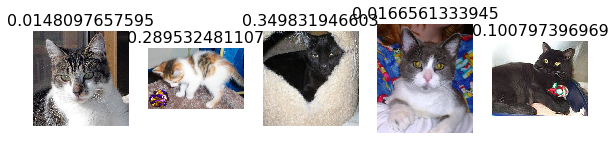

In [103]:
cat_indices = np.where(test_probabilities<.5)
five_cat_indices = cat_indices[0][:5]
plots_idx(test_batches, five_cat_indices, test_probabilities[five_cat_indices])

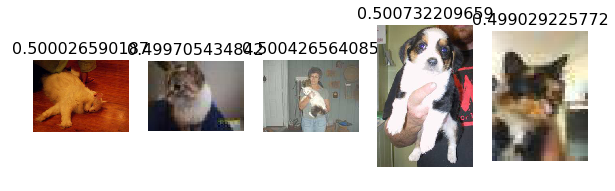

In [106]:
import utils
most_uncertain = np.argsort(np.abs(test_probabilities-0.5))
plots_idx(test_batches, most_uncertain[:5], test_probabilities[most_uncertain[:5]])

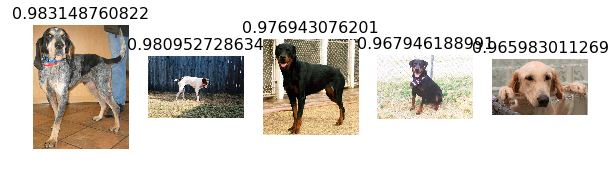

In [109]:
most_confident_dogs = np.argsort(test_probabilities)[::-1][:5]
plots_idx(test_batches,most_confident_dogs, test_probabilities[most_confident_dogs])

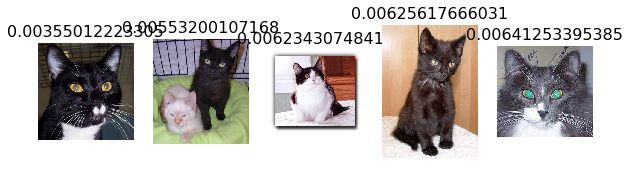

In [110]:
most_confident_cats = np.argsort(test_probabilities)[:5]
plots_idx(test_batches,most_confident_cats, test_probabilities[most_confident_cats])